<a href="https://colab.research.google.com/github/m8ncat/MLops-4/blob/main/MLops_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing with Disaster Tweets!**



# Настройка ClearML

In [1]:
!pip install clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [2]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=M2UPT3SQB250YO3RZWZX
%env CLEARML_API_SECRET_KEY=uTb4gxbnCVsZ92Y2vOo81J0NSZMDxTrP4ijUrzDYHyWsW0nA4g

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=M2UPT3SQB250YO3RZWZX
env: CLEARML_API_SECRET_KEY=uTb4gxbnCVsZ92Y2vOo81J0NSZMDxTrP4ijUrzDYHyWsW0nA4g


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Add the following two lines to your code, to have ClearML automatically log your experiment
from clearml import Task, Logger

task = Task.init(project_name='MLops-4', task_name='Gradient Boosting')

ClearML Task: created new task id=e1c82a178cc040b087d1d10a3d50d3a3
2024-01-19 00:38:19,675 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/32ac8f7a961047acb4a06583ff6a9760/experiments/e1c82a178cc040b087d1d10a3d50d3a3/output/log


## Импорт библиотек

In [4]:
from google.colab import files

import pandas as pd
import re
import numpy as np

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

## Подключение к Kaggle для загрузки данных прямо из браузера

In [6]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Загружаем данные с Kaggle

In [7]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 1.43MB/s]
100% 593k/593k [00:00<00:00, 1.39MB/s]


In [8]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Загружаем данные в Pandas

In [9]:
df_train = pd.read_csv('train.csv')
df_train = df_train[['text', 'target']]
df_train.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,I'm on top of the hill and I can see a fire in the woods...,1
8,There's an emergency evacuation happening now in the building across the street,1
9,I'm afraid that the tornado is coming to our area...,1


In [10]:
df_test = pd.read_csv('test.csv')
df_test = df_test[['id', 'text']]
df_test.head(10)

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone."
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
5,12,We're shaking...It's an earthquake
6,21,"They'd probably still show more life than Arsenal did yesterday, eh? EH?"
7,22,Hey! How are you?
8,27,What a nice hat?
9,29,Fuck off!


## Анализ данных

In [11]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


# Раскрываем сокращённые слова


`'d -> would`

In [12]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.4 MB/s eta 0:00:00


In [13]:
import contractions

In [14]:
df_train['no_contract'] = df_train['text'].apply(lambda x: ' '.join([contractions.fix(word) for word in str(x).replace('`', '\'').split()]))
df_train.head(10)

,text,target,length,no_contract
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California",1,65,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,110,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,95,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas"
7,I'm on top of the hill and I can see a fire in the woods...,1,59,I am on top of the hill and I can see a fire in the woods...
8,There's an emergency evacuation happening now in the building across the street,1,79,There is an emergency evacuation happening now in the building across the street
9,I'm afraid that the tornado is coming to our area...,1,52,I am afraid that the tornado is coming to our area...


In [15]:
df_test['no_contract'] = df_test['text'].apply(lambda x: ' '.join([contractions.fix(word) for word in str(x).replace('`', '\'').split()]))
df_test.head(10)

,id,text,length,no_contract
0,0,Just happened a terrible car crash,34,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",64,"Heard about #earthquake is different cities, stay safe everyone."
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 in China and Taiwan
5,12,We're shaking...It's an earthquake,34,We are shaking...It is an earthquake
6,21,"They'd probably still show more life than Arsenal did yesterday, eh? EH?",72,"They would probably still show more life than Arsenal did yesterday, eh? EH?"
7,22,Hey! How are you?,17,Hey! How are you?
8,27,What a nice hat?,16,What a nice hat?
9,29,Fuck off!,9,Fuck off!


## Стоп-слова

In [16]:
import nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords

In [19]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Очистка и предобработка текстовых данных

In [20]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
stop_words = stopwords.words('english')

In [22]:
def clean_text(text, stemming=False, lemmatization=True):
    text = str(text).lower() # перевод букв в нижний регистр
    text = text.strip() # удаление пробелов в начале и в конце строки
    text = re.sub(r'[^\w\s]', '', text) # удаление знаков препинания

    # удаление стоп слов
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # стемминг
    if stemming == True:
      ps = nltk.stem.porter.PorterStemmer()
      text = [ps.stem(word) for word in text.split()]

    # лемматизация
    if lemmatization == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      text = [lem.lemmatize(word) for word in text.split()]

    text = ' '.join(text)
    return text

In [23]:
df_train['clean'] = df_train['no_contract'].apply(lambda row: clean_text(row, stemming=False, lemmatization=True))
df_train.head()

,text,target,length,no_contract,clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,resident asked shelter place notified officer evacuation shelter place order expected
3,"13,000 people receive #wildfires evacuation orders in California",1,65,"13,000 people receive #wildfires evacuation orders in California",13000 people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,got sent photo ruby alaska smoke wildfire pours school


In [24]:
df_test['clean'] = df_test['no_contract'].apply(lambda row: clean_text(row, stemming=False, lemmatization=True))
df_test.head()

,id,text,length,no_contract,clean
0,0,Just happened a terrible car crash,34,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, stay safe everyone.",64,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquake different city stay safe everyone
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",96,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond goose fleeing across street cannot save
3,9,Apocalypse lighting. #Spokane #wildfires,40,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


## Обучение модели

In [25]:
x_train = df_train['clean']
y_train = df_train['target']

In [26]:
vectorizer = TfidfVectorizer(max_features=1500, ngram_range=(1,2))
vectorizer.fit(x_train)

TfidfVectorizer(max_features=1500, ngram_range=(1, 2))

In [27]:
x_train, y_train = vectorizer.transform(df_train['clean']), df_train['target']

## LogisticRegression

In [39]:
# Создание и обучение модели
classifier = LogisticRegression(random_state=2).fit(x_train, y_train)

# Предсказание на тренировочных данных и вычисление F1-меры
train = classifier.predict(x_train)
f1_train = f1_score(y_train, train)
print(f1_train)

0.7994744621448513


## Support Vector Machine (SVM)

In [40]:
# Создание и обучение модели
svm_classifier = SVC(random_state=2)
svm_classifier.fit(x_train, y_train)

# Предсказание на тренировочных данных и вычисление F1-меры
train_svm = svm_classifier.predict(x_train)
f1_train_svm = f1_score(y_train, train_svm)
print(f1_train_svm)

0.9035910708508573


## Random Forest

In [41]:
# Создание и обучение модели
rf_classifier = RandomForestClassifier(random_state=2)
rf_classifier.fit(x_train, y_train)

# Предсказание на тренировочных данных и вычисление F1-меры
train_rf = rf_classifier.predict(x_train)
f1_train_rf = f1_score(y_train, train_rf)
print(f1_train_rf)

0.9676720804331013


## Gradient Boosting

In [31]:
# Создание и обучение модели
gb_classifier = GradientBoostingClassifier(random_state=2)
gb_classifier.fit(x_train, y_train)

# Предсказание на тренировочных данных и вычисление F1-меры
train_gb = gb_classifier.predict(x_train)
f1_train_gb = f1_score(y_train, train_gb)
print(f1_train_gb)

0.647209623348452


In [32]:
# Добавление метрики в трекинг эксперимента
task.get_logger().report_scalar(title='F1', series='metrics', value=f1_train_gb, iteration=1)

In [33]:
task.upload_artifact(name='F1', artifact_object={'F1': f1_train_gb})

True

In [34]:
task.close()

## Работа с тестовыми данными

In [35]:
x_test = df_test['clean']
x_test = vectorizer.transform(df_test['clean'])

In [36]:
test = rf_classifier.predict(x_test)
id = df_test[['id']]
result = pd.DataFrame(test)
df_submission = pd.concat([id, result], axis = 1)
df_submission = df_submission.rename(columns = {0:'target'})

## Загрузка ответа на Kaggle

In [37]:
df_submission.to_csv('submission.csv', index=False)

In [38]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "task"

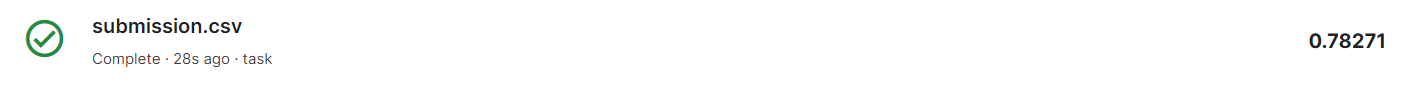